# Skip the sliding windows step once you've found the lines

![image1](img/screen-shot-2017-01-28-at-12.39.43-pm.png)

We've now built an algorithm that uses sliding windows to track the lane lines out into the distance. However, using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lines don't necessarily move a lot from frame to frame.

In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous line position, like in the above image. The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame.

This is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to your sliding windows search or other method to rediscover them.

Let's walk through one way to do this, and then you'll build it out further in a quiz below.

## Use the previous polynomial to skip the sliding window

In the previous quiz, we used **left_lane_inds** and **right_lane_inds** to hold the pixel values contained within the boundaries of a given sliding window. This time, we'll take the polynomial functions we fit before (**left_fit** and **right_fit**), along with a hyperparameter **margin**, to determine which activated pixels fall into the green shaded areas from the above image. Note that this margin can be a different value than the one originally used for your sliding windows!

To implement this in the below quiz, you'll want to grab only those pixels with x-values that are +/- your **margin** from your polynomial lines. Note that you'll only need to implement **left_lane_inds** and **right_lane_inds** in the quiz - most of the surrounding code, ignoring iterating through the windows, is the same as before!

The way we'll visualize this is a bit different than last time around, however, so make sure to pay attention to that if you want to visualize this step while working on your project.

1. Fit a polynomial to all the relevant pixels you've found in your sliding windows in **fit_poly()**.
2. Set the area to search for activated pixels based on margin out from your fit polynomial within **search_around_poly**. Note that the quiz grader expects a **margin** of **100** pixels, but you can tune this as part of your own project!

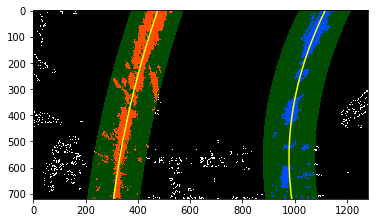

In [2]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('img/warped-example.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
                    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)
plt.show()

## Fitting on Large Curves
One thing to consider in our current implementation of sliding window search is what happens when we arrive at the left or right edge of an image, such as when there is a large curve on the road ahead. If minpix is not achieved (i.e. the curve ran off the image), the starting position of our next window doesn't change, so it is just positioned directly above the previous window. This will repeat for however many windows are left in nwindows, stacking the sliding windows vertically against the side of the image, and likely leading to an imperfect polynomial fit.

Can you think of a way to solve this issue? If you want to tackle the curves on the harder challenge video as part of the project, you might want to include this in your lane finding algorithm.